[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/okada-tak/deep-learning-from-scratch/blob/master/notebooks/ch07.ipynb)
[![Open in SageMaker Studio Lab](https://studiolab.sagemaker.aws/studiolab.svg)](https://studiolab.sagemaker.aws/import/github/okada-tak/deep-learning-from-scratch/blob/master/notebooks/ch07.ipynb)  
# ■ch07/xxxx.py以外は追記（岡田）
# 7章 畳み込みニューラルネットワーク のまとめ
- CNNは、これまでの全結合層のネットワークに対して、畳み込み層とプーリング層が新たに加わる。  
- 畳み込み層とプーリング層は、im2col(画像を行列に展開する関数)を用いるとシンプルで効率の良い実装ができる。  
- CNNの可視化によって、層が深くなるにつれて高度な情報が抽出されていく様子がわかる。  
- CNNの代表的なネットワークには、LeNetとAlexNetがある。  
- ディープラーニングの発展に、ビッグデータとGPUが大きく貢献している。

# 7.1 全体の構造
- 全結合５層  
　入力 → Affine-ReLU → Affine-ReLU → Affine-ReLU → Affine-ReLU → Affine-Softmax → 出力  
- CNNの例  
　入力 → Conv-ReLU-Pooling → Conv-ReLU-Pooling → Conv-ReLU → Affine-ReLU → Affine-Softmax → 出力  

# 7.2 畳み込み層
## 7.2.1 全結合層の問題点
- データの形状が無視されてしまう。  
　画像データ：縦×横×チャネル方向の3次元形状  

用語：入力データ、出力データ  
　入力特徴マップ → Conv → 出力特徴マップ

## 7.2.2 畳み込み演算
用語：フィルター(重み)  
　カーネル  

p.209の例は、パディングなし、ストライド1  

入力データ [積和] フィルター(重み) → 中間出力＋バイアス → 出力データ  

フィルター適用後のデータに対して１つ（１×１）のバイアスをすべての要素に加算する。

## 7.2.3 パディング
(4,4)の入力データ [積和] (3,3)のフィルター → (2,2)の出力データ  
↑小さくなってしまい、層を重ねるとどんどん小さくなっていく。  

(4,4)の入力データ → 幅1のパディング → (6,6)の入力データ  
(6,6)の入力データ [積和] (3,3)のフィルター → (4,4)の出力データ  

## 7.2.4 ストライド
フィルターを適用する位置の間隔。  
(7,7)の入力データ → ストライド2 → (3,3)の出力データ  

$OH=\frac{H+2P-FH}{S}+1$  

$OW=\frac{W+2P-FW}{S}+1$  

入力サイズ：$(H,W)$  
フィルターサイズ：$(FH,FW)$  
出力サイズ：$(OH,OW)$  
パディング：$P$  
ストライド：$S$  

$S$で割り切れるように設定すること。（ストライドを2以上にするなら）

## 7.2.5 3次元データの畳み込み演算
チャンネルごとに入力データとフィルターの畳み込み演算を行い、結果を加算してひとつの出力。  
※出力のチャンネル数は1ということ。
- 入力データとフィルターのチャンネル数は同じ値にする。  
- フィルターのサイズは任意。ただし、チャンネルごとのフィルターのサイズはすべて同じ。  

※この意味は？R,G,Bチャンネルがあったとして、フィルターのチャンネル数は3。R,G,Bのフィルターのサイズはすべて同じ（R,G,Bでサイズが違ってはいけない。サイズ自体は任意）。ということかな？7.2.6の式からみるとたぶんそう。

## 7.2.6 ブロックで考える
入力データ(C,H,W) [積和] フィルター(C,FH,FW) → 出力データ(1,OH,OW)  

疑問：  
p.217 畳み込み演算の出力をチャンネル方向にも複数持たせるには複数のフィルターを用いる、とあるが、FN個のフィルターであってFC個ではない。「チャンネル方向」という意味がよくわからない。  

複数のフィルターによる畳み込み演算の例：  
入力データ(C,H,W) [積和] フィルター(FN,C,FH,FW) → 出力データ(FN,OH,OW)  

バイアス項も追加すると結局以下：  
入力データ(C,H,W) [積和] フィルター(FN,C,FH,FW) → 中間出力(FN,OH,OW)＋バイアス(FN,1,1) → 出力データ(FN,OH,OW)  
※バイアスはFN個のチャンネルごとに1つ。

## 7.2.7 バッチ処理
(batch_num, channel, height, width)の4次元で表現する。

N個のデータに対してバッチ処理：  
入力データ(N,C,H,W) [積和] フィルター(FN,C,FH,FW) → 中間出力(N,FN,OH,OW)＋バイアス(FN,1,1) → 出力データ(N,FN,OH,OW)  
※N回分の処理を1回で行っている。

# 7.3 プーリング層
縦・横方向の空間を小さくする演算。  
一般的に、プーリングのウィンドウサイズとストライドは同じ値に設定する。

Maxプーリングの他にAverageプーリングなどがあるが画像認識では主にMaxプーリングが使われる。

## 7.3.1 プーリング層の特徴
- 学習するパラメータがない。  
- チャンネル数は変化しない。  
- 微小な位置変化に対してロバスト（頑健）。  

# 7.4 Convolution / Poolingレイヤの実装
## 7.4.1 4次元配列


In [4]:
import numpy as np

x = np.random.rand(10, 1, 28, 28)
x.shape

(10, 1, 28, 28)

In [2]:
x[0].shape

(1, 28, 28)

In [3]:
x[1].shape

(1, 28, 28)

In [4]:
x[0, 0]

array([[0.71412064, 0.13509261, 0.88070301, 0.56992325, 0.35064352,
        0.36593439, 0.0781417 , 0.03726013, 0.42891319, 0.68147575,
        0.3424712 , 0.20787797, 0.25711263, 0.39118542, 0.63286136,
        0.81230085, 0.66671711, 0.09124888, 0.39965205, 0.53432956,
        0.86027159, 0.40041664, 0.59320584, 0.81091043, 0.55510577,
        0.58140506, 0.41930415, 0.18501125],
       [0.04430769, 0.36680073, 0.52128287, 0.7157661 , 0.24828306,
        0.80467658, 0.82375671, 0.02214566, 0.09077362, 0.79645532,
        0.44659174, 0.88374228, 0.49291845, 0.32742891, 0.5127306 ,
        0.98535722, 0.60468284, 0.25827405, 0.52896059, 0.45912675,
        0.72763567, 0.59885562, 0.05063273, 0.31118886, 0.00927957,
        0.08972246, 0.67256007, 0.65674929],
       [0.34398422, 0.4812563 , 0.89688977, 0.98191953, 0.43209336,
        0.18216453, 0.52950717, 0.24001336, 0.09834772, 0.94291951,
        0.50158136, 0.19494433, 0.19796849, 0.08086533, 0.8879106 ,
        0.57912239, 0.2224

In [5]:
x[0][0]

array([[0.71412064, 0.13509261, 0.88070301, 0.56992325, 0.35064352,
        0.36593439, 0.0781417 , 0.03726013, 0.42891319, 0.68147575,
        0.3424712 , 0.20787797, 0.25711263, 0.39118542, 0.63286136,
        0.81230085, 0.66671711, 0.09124888, 0.39965205, 0.53432956,
        0.86027159, 0.40041664, 0.59320584, 0.81091043, 0.55510577,
        0.58140506, 0.41930415, 0.18501125],
       [0.04430769, 0.36680073, 0.52128287, 0.7157661 , 0.24828306,
        0.80467658, 0.82375671, 0.02214566, 0.09077362, 0.79645532,
        0.44659174, 0.88374228, 0.49291845, 0.32742891, 0.5127306 ,
        0.98535722, 0.60468284, 0.25827405, 0.52896059, 0.45912675,
        0.72763567, 0.59885562, 0.05063273, 0.31118886, 0.00927957,
        0.08972246, 0.67256007, 0.65674929],
       [0.34398422, 0.4812563 , 0.89688977, 0.98191953, 0.43209336,
        0.18216453, 0.52950717, 0.24001336, 0.09834772, 0.94291951,
        0.50158136, 0.19494433, 0.19796849, 0.08086533, 0.8879106 ,
        0.57912239, 0.2224

## 7.4.2 im2colによる展開
im2col : image to column のこと。  

4次元を2次元に展開する。  
横方向に1列。（各ストライドごとに1行のイメージ。）

展開後：  
- 畳み込み層のフィルターを1列(縦方向)に展開する。  
- im2colした各行と↑のフィルターの各列で行列演算を行う。  
- 2次元の出力データが得られるのでreshapeして出力データを整形する。

## 7.4.3 Convolutionレイヤの実装
im2col(input_data, filterNh, filter_w, stride=1, pad=0)  
- input_data：(データ数, チャンネル, 高さ, 横幅)の4次元配列からなる入力データ。  
- filter_h：フィルターの高さ。  
- filter_w：フィルターの横幅。  
- stride：ストライド  
- pad：パディング  


# ■追記（岡田）Colaboratory用
Google Colaboratoryの場合、Google Driveに  
dl-from-scratch/ch07  
というフォルダを用意し、そこにこのjupyter notebookを配置。  
(dl-from-scratchの部分は任意。)  
また、datasetフォルダとcommonフォルダを
dl-from-scratch/dataset  
dl-from-scratch/common
にコピーしておく。  

以下のセルでGoogle Driveをマウント。許可を求められるので許可する。

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# ■追記（岡田）Colaboratory用
chdirする。

In [2]:
import sys,os
os.chdir('/content/drive/My Drive/dl-from-scratch/ch07')
os.getcwd()

'/content/drive/My Drive/dl-from-scratch/ch07'

In [5]:
import sys, os
sys.path.append(os.pardir)
from common.util import im2col

x1 = np.random.rand(1,3,7,7)
col1 = im2col(x1, 5, 5, stride=1, pad=0)
print(col1.shape)

x2 = np.random.rand(10,3,7,7)
col2 = im2col(x2, 5, 5, stride=1, pad=0)
print(col2.shape)

(9, 75)
(90, 75)


★？？？★  
ここよくわからない。  
75は、3(CH)×5(FH)×5(FW)なのはわかる。  
9はどこからでてきた？  
H=7, W=7, FH=5, FW=5, S=1, pad=0なので、OH=OW=3なので、OH×OW=9、ということ？？  

↓読んだけど、、、、うーん？？  
im2colに慣れるための最初の一歩　～何をしているの？～  
https://aihack.aijobcolle.com/u/lukapla/ct2p5cc6ik2rdr  

7.4.1-2：im2colの実装【ゼロつく1のノート(実装)】  
https://www.anarchive-beta.com/entry/2020/08/23/180000

★★いったん詳細は保留する。★★

class Convolutionは、common/layers.pyにある。

## 7.4.4 Poolingレイヤの実装
p.228の図7-21は、4×4の入力データに、2×2のMaxプーリングをストライド2で実施する例。  
Maxを求めたいブロックを1行になるようにim2colで展開してnp.maxで行の最大値をとるだけ。  


# 7.5 CNNの実装
- SimpleConvNet  
　入力 → Conv-ReLU-Pooling → Affine-ReLU → Affine-Softmax → 出力  

# ch07/simple_convnet.py

In [3]:
import sys, os
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import pickle
import numpy as np
from collections import OrderedDict
from common.layers import *
from common.gradient import numerical_gradient


class SimpleConvNet:
    """単純なConvNet

    conv - relu - pool - affine - relu - affine - softmax
    
    Parameters
    ----------
    input_size : 入力サイズ（MNISTの場合は784）
    hidden_size_list : 隠れ層のニューロンの数のリスト（e.g. [100, 100, 100]）
    output_size : 出力サイズ（MNISTの場合は10）
    activation : 'relu' or 'sigmoid'
    weight_init_std : 重みの標準偏差を指定（e.g. 0.01）
        'relu'または'he'を指定した場合は「Heの初期値」を設定
        'sigmoid'または'xavier'を指定した場合は「Xavierの初期値」を設定
    """
    def __init__(self, input_dim=(1, 28, 28), 
                 conv_param={'filter_num':30, 'filter_size':5, 'pad':0, 'stride':1},
                 hidden_size=100, output_size=10, weight_init_std=0.01):
        filter_num = conv_param['filter_num']
        filter_size = conv_param['filter_size']
        filter_pad = conv_param['pad']
        filter_stride = conv_param['stride']
        input_size = input_dim[1]
        conv_output_size = (input_size - filter_size + 2*filter_pad) / filter_stride + 1
        pool_output_size = int(filter_num * (conv_output_size/2) * (conv_output_size/2))

        # 重みの初期化
        self.params = {}
        self.params['W1'] = weight_init_std * \
                            np.random.randn(filter_num, input_dim[0], filter_size, filter_size)
        self.params['b1'] = np.zeros(filter_num)
        self.params['W2'] = weight_init_std * \
                            np.random.randn(pool_output_size, hidden_size)
        self.params['b2'] = np.zeros(hidden_size)
        self.params['W3'] = weight_init_std * \
                            np.random.randn(hidden_size, output_size)
        self.params['b3'] = np.zeros(output_size)

        # レイヤの生成
        self.layers = OrderedDict()
        self.layers['Conv1'] = Convolution(self.params['W1'], self.params['b1'],
                                           conv_param['stride'], conv_param['pad'])
        self.layers['Relu1'] = Relu()
        self.layers['Pool1'] = Pooling(pool_h=2, pool_w=2, stride=2)
        self.layers['Affine1'] = Affine(self.params['W2'], self.params['b2'])
        self.layers['Relu2'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W3'], self.params['b3'])

        self.last_layer = SoftmaxWithLoss()

    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)

        return x

    def loss(self, x, t):
        """損失関数を求める
        引数のxは入力データ、tは教師ラベル
        """
        y = self.predict(x)
        return self.last_layer.forward(y, t)

    def accuracy(self, x, t, batch_size=100):
        if t.ndim != 1 : t = np.argmax(t, axis=1)
        
        acc = 0.0
        
        for i in range(int(x.shape[0] / batch_size)):
            tx = x[i*batch_size:(i+1)*batch_size]
            tt = t[i*batch_size:(i+1)*batch_size]
            y = self.predict(tx)
            y = np.argmax(y, axis=1)
            acc += np.sum(y == tt) 
        
        return acc / x.shape[0]

    def numerical_gradient(self, x, t):
        """勾配を求める（数値微分）

        Parameters
        ----------
        x : 入力データ
        t : 教師ラベル

        Returns
        -------
        各層の勾配を持ったディクショナリ変数
            grads['W1']、grads['W2']、...は各層の重み
            grads['b1']、grads['b2']、...は各層のバイアス
        """
        loss_w = lambda w: self.loss(x, t)

        grads = {}
        for idx in (1, 2, 3):
            grads['W' + str(idx)] = numerical_gradient(loss_w, self.params['W' + str(idx)])
            grads['b' + str(idx)] = numerical_gradient(loss_w, self.params['b' + str(idx)])

        return grads

    def gradient(self, x, t):
        """勾配を求める（誤差逆伝搬法）

        Parameters
        ----------
        x : 入力データ
        t : 教師ラベル

        Returns
        -------
        各層の勾配を持ったディクショナリ変数
            grads['W1']、grads['W2']、...は各層の重み
            grads['b1']、grads['b2']、...は各層のバイアス
        """
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 設定
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Conv1'].dW, self.layers['Conv1'].db
        grads['W2'], grads['b2'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W3'], grads['b3'] = self.layers['Affine2'].dW, self.layers['Affine2'].db

        return grads
        
    def save_params(self, file_name="params.pkl"):
        params = {}
        for key, val in self.params.items():
            params[key] = val
        with open(file_name, 'wb') as f:
            pickle.dump(params, f)

    def load_params(self, file_name="params.pkl"):
        with open(file_name, 'rb') as f:
            params = pickle.load(f)
        for key, val in params.items():
            self.params[key] = val

        for i, key in enumerate(['Conv1', 'Affine1', 'Affine2']):
            self.layers[key].W = self.params['W' + str(i+1)]
            self.layers[key].b = self.params['b' + str(i+1)]

# ch07/gradient_check.py

In [7]:
import numpy as np

network = SimpleConvNet(input_dim=(1,10, 10), 
                        conv_param = {'filter_num':10, 'filter_size':3, 'pad':0, 'stride':1},
                        hidden_size=10, output_size=10, weight_init_std=0.01)

X = np.random.rand(100).reshape((1, 1, 10, 10))
T = np.array([1]).reshape((1,1))

grad_num = network.numerical_gradient(X, T)
grad = network.gradient(X, T)

for key, val in grad_num.items():
    print(key, np.abs(grad_num[key] - grad[key]).mean())

W1 2.0644789112570126e-10
b1 3.6484593719397686e-10
W2 5.408784320457862e-11
b2 0.00028426338386853563
W3 3.775743224111263e-10
b3 1.7989346901142734e-07


# ch07/train_convnet.py

↓実行時間がかなりかかるので注意。

ストリーミング出力は最後の 5000 行に切り捨てられました。
train loss:0.0037612765640775425
train loss:0.006746911242468889
train loss:0.0013883427328885778
train loss:0.0013928339138518438
train loss:0.0010340436784107242
train loss:0.009505522974810741
train loss:0.0005315124782325794
train loss:0.006794014438698923
train loss:0.01586195071081634
train loss:0.0006334181938564128
train loss:0.0018237072612314032
train loss:0.001999724486769207
train loss:0.0002633985154324525
train loss:0.0032881942056281767
train loss:0.018445277442150954
train loss:0.008843006869686464
train loss:0.007086956579464744
train loss:0.000604181148209055
train loss:0.015397024012363423
train loss:0.004928752892719937
train loss:0.0009719689059962778
train loss:5.759033086925582e-05
train loss:0.014398503061781358
train loss:0.0027178904967803037
train loss:0.004731622878997716
train loss:0.008850924048642133
train loss:0.0004615902743441415
train loss:0.0017230219079879638
train loss:0.00193975912261261
train loss:0.005943349463342

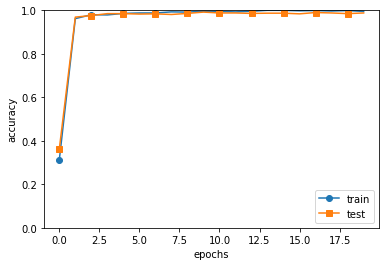

In [8]:
import sys, os
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.trainer import Trainer

# データの読み込み
(x_train, t_train), (x_test, t_test) = load_mnist(flatten=False)

# 処理に時間のかかる場合はデータを削減 
#x_train, t_train = x_train[:5000], t_train[:5000]
#x_test, t_test = x_test[:1000], t_test[:1000]

max_epochs = 20

network = SimpleConvNet(input_dim=(1,28,28), 
                        conv_param = {'filter_num': 30, 'filter_size': 5, 'pad': 0, 'stride': 1},
                        hidden_size=100, output_size=10, weight_init_std=0.01)
                        
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=max_epochs, mini_batch_size=100,
                  optimizer='Adam', optimizer_param={'lr': 0.001},
                  evaluate_sample_num_per_epoch=1000)
trainer.train()

# パラメータの保存
network.save_params("../ch07/params.pkl")
print("Saved Network Parameters!")

# グラフの描画
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, trainer.train_acc_list, marker='o', label='train', markevery=2)
plt.plot(x, trainer.test_acc_list, marker='s', label='test', markevery=2)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()


# 7.6 CNNの可視化
## 7.6.1 1層目の重みの可視化
畳み込み層のフィルターはエッジ（色が変化する境目）やブロブ（塊のある領域）などのプリミティブな情報を抽出する。

# ch07/visualize_filter.py

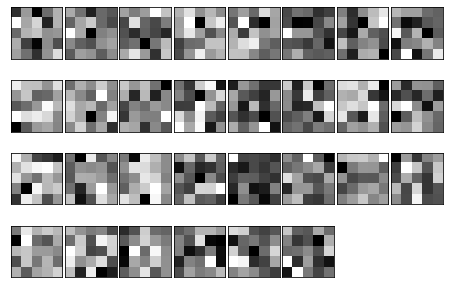

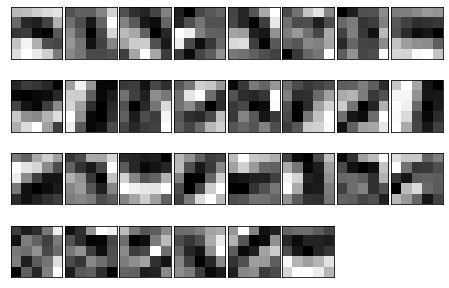

In [4]:
import numpy as np
import matplotlib.pyplot as plt

def filter_show(filters, nx=8, margin=3, scale=10):
    """
    c.f. https://gist.github.com/aidiary/07d530d5e08011832b12#file-draw_weight-py
    """
    FN, C, FH, FW = filters.shape
    ny = int(np.ceil(FN / nx))

    fig = plt.figure()
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

    for i in range(FN):
        ax = fig.add_subplot(ny, nx, i+1, xticks=[], yticks=[])
        ax.imshow(filters[i, 0], cmap=plt.cm.gray_r, interpolation='nearest')
    plt.show()


network = SimpleConvNet()
# ランダム初期化後の重み
filter_show(network.params['W1'])

# 学習後の重み
network.load_params("../ch07/params.pkl")
filter_show(network.params['W1'])

# ch07/apply_filter.py

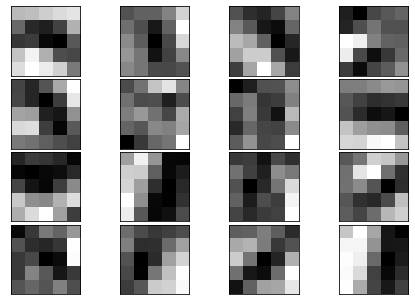

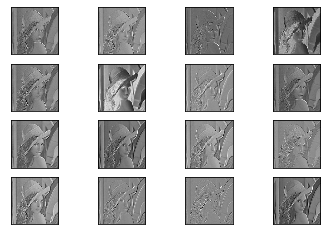

In [5]:

import sys, os
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
from common.layers import Convolution

def filter_show(filters, nx=4, show_num=16):
    """
    c.f. https://gist.github.com/aidiary/07d530d5e08011832b12#file-draw_weight-py
    """
    FN, C, FH, FW = filters.shape
    ny = int(np.ceil(show_num / nx))

    fig = plt.figure()
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

    for i in range(show_num):
        ax = fig.add_subplot(4, 4, i+1, xticks=[], yticks=[])
        ax.imshow(filters[i, 0], cmap=plt.cm.gray_r, interpolation='nearest')


network = SimpleConvNet(input_dim=(1,28,28), 
                        conv_param = {'filter_num':30, 'filter_size':5, 'pad':0, 'stride':1},
                        hidden_size=100, output_size=10, weight_init_std=0.01)

# 学習後の重み
network.load_params("../ch07/params.pkl")

filter_show(network.params['W1'], 16)

img = imread('../dataset/lena_gray.png')
img = img.reshape(1, 1, *img.shape)

fig = plt.figure()

w_idx = 1

for i in range(16):
    w = network.params['W1'][i]
    b = 0  # network.params['b1'][i]

    w = w.reshape(1, *w.shape)
    #b = b.reshape(1, *b.shape)
    conv_layer = Convolution(w, b) 
    out = conv_layer.forward(img)
    out = out.reshape(out.shape[2], out.shape[3])
    
    ax = fig.add_subplot(4, 4, i+1, xticks=[], yticks=[])
    ax.imshow(out, cmap=plt.cm.gray_r, interpolation='nearest')

plt.show()

## 7.6.2 階層構造による情報抽出
層が深くなるにつれて、抽出される情報はより抽象化される。  
単純なエッジ→テクスチャ→より複雑な物体のパーツ、など。

# 7.7 代表的なCNN

## 7.7.1 LeNet
1998年に提案されたCNNの元祖。  
現在のCNNとの違い。  
- 活性化関数がシグモイド関数。（現在はReLU）。  
- サイズ縮小がサブサンプリング。（現在はMaxプーリング）。  

※「現在」とあるが、本書執筆は2016年であることに注意。

## 7.7.2 AlexNet
2012年にディープラーニングが注目されるきっかけとなった。  
LeNetとの違い。  
- 活性化関数がReLU。
- LRN(Local Response Normalization)という局所的正規化を行う層を用いる。  
- Dropoutを使用。